In [1]:
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
import math
from sklearn import decomposition
from sklearn.preprocessing import PolynomialFeatures

In [2]:
'''
input-
y_pred, y_true shape is (n,) (NOT in one-hot representation)
multi-class such that ypred,ytrue has values in 0,1,2,..,label-1

In confusion matrix, it is assumed that there are 6 labels.

output-
precisions, recalls, F1s numpy arrays of shape (no. of labels,)
confusion matrix - numpy matrix (label,label)
'''
def classification_performance_metrics(y_pred, y_true, exp_name):
    
    y_pred = y_pred.astype('uint8')
    y_true = y_true.astype('uint8')
    
    confusion_matrix = np.zeros((6,6)) #left side - actual, top side - predicted
    for true_label in range(6):
        true_indices = y_true==true_label
        for pred_label in range(6):
            check_pred_labels = y_pred[true_indices]
            confusion_matrix[true_label][pred_label]= (check_pred_labels == pred_label).sum()
    confusion_matrix/=(confusion_matrix.sum(axis=1,keepdims=True))    #normalise it - dividing by column sum

    n=y_true.shape
    
    tp_indices = y_pred==y_true
    tp = y_true[tp_indices]
    
    true_y_per_class = np.bincount(y_true)
    labels = true_y_per_class.shape[0]
    
    tp_per_class = np.zeros((labels,))
    tp_per_class[:np.bincount(tp).shape[0]] = np.bincount(tp)
    predicted_y_per_class = np.zeros((labels,))
    predicted_y_per_class[:np.bincount(y_pred).shape[0]] = np.bincount(y_pred)
    
    precisions, recalls, F1s = [], [], []
    #precision, recall, F1 for each class
    for i in range(tp_per_class.shape[0]):
        TP = tp_per_class[i]
        TN = tp_per_class.sum() - TP
        FP = predicted_y_per_class[i] - TP
        FN = true_y_per_class[i] - TP
        
        precision = TP/(TP+FP) if TP+FP!=0 else 0
        recall = TP/(TP+FN) if TP+FN!=0 else 0
        F1 = 2*TP/(2*TP+FP+FN) if TP+FP+FN!=0 else 0
        FPR = FP/(FP+TN) if FP+TN!=0 else 0

        precisions.append(precision)
        recalls.append(recall)
        F1s.append(F1)
        
    if exp_name!=None:
        #save csv files
        categories=["AbdomenCT","BreastMRI","ChestCT","CXR","Hand","HeadCT"]
        dikt = {}
        dikt['Precision']=np.round(precisions,3)
        dikt['Recall']=np.round(recalls,3)
        dikt['F1']=np.round(F1s,3)

        df = pd.DataFrame(data=dikt,index=categories)
        df.to_csv('%s_perClass.csv'%exp_name)
        df = pd.DataFrame(data=np.round(confusion_matrix,3),index=categories,columns=categories)
        df.to_csv('%s_ConfMat.csv'%exp_name)
    
    
    precisions=np.array(precisions)
    recalls=np.array(recalls)
    F1s=np.array(F1s)
    macro_F1=F1s.mean()
    
    return precisions, recalls, F1s, macro_F1, confusion_matrix

def accuracy(y_pred, y_true):
    return (y_pred==y_true).sum()/y_true.shape[0]

### Data Preprocessing

In [3]:
category = {}
category[0] = "AbdomenCT"
category[1] = "BreastMRI"
category[2] = "ChestCT"
category[3] = "CXR"
category[4] = "Hand"
category[5] = "HeadCT"
path = './Medical_MNIST/'

In [4]:
train_data=np.load('train.npy').astype(np.float64) #loading as float because i have to normalise later
np.random.shuffle(train_data)
TEST_data=np.load('test.npy').astype(np.float64)
print(train_data.shape, train_data.dtype)
print(TEST_data.shape, TEST_data.dtype)

(47163, 4097) float64
(11791, 4097) float64


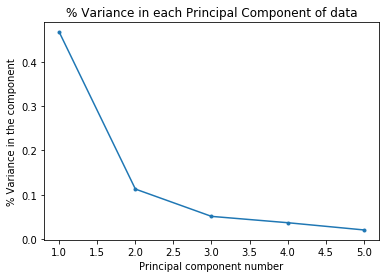

In [5]:
# using PCA to find appropriate number of components

pca=decomposition.PCA(n_components=5)
pca.fit(train_data[:,:-1])
variances=pca.explained_variance_ratio_
plt.title('% Variance in each Principal Component of data')
plt.xlabel('Principal component number')
plt.ylabel('% Variance in the component')
plt.plot([1,2,3,4,5],variances,marker='.')
plt.savefig('PCA.png')
plt.show()

In [6]:
pca=decomposition.PCA(n_components=2)
pca.fit(train_data[:,:-1])

transformed_train_data_X = pca.transform(train_data[:,:-1])
transformed_TEST_data_X = pca.transform(TEST_data[:,:-1])

train_data = np.hstack((transformed_train_data_X,train_data[:,-1:]))
TEST_data = np.hstack((transformed_TEST_data_X, TEST_data[:,-1:]))
print(train_data.shape, TEST_data.shape)

#computing mean and stddev from whole train set (0.80*total data)
mean = train_data[:,:-1].mean(axis=0,keepdims=True)
stddev = train_data[:,:-1].std(axis=0,keepdims=True)

train_data[:,:-1]-=mean
TEST_data[:,:-1]-=mean
train_data[:,:-1]/=stddev
TEST_data[:,:-1]/=stddev

# Data is normalised and in two dimensions

(47163, 3) (11791, 3)


In [7]:
Cross_Validation_data=np.array_split(train_data,5)
print(len(Cross_Validation_data))

X_TEST,y_TEST = TEST_data[:,:-1],TEST_data[:,-1:]
print(X_TEST.shape, y_TEST.shape)

5
(11791, 2) (11791, 1)


In [8]:
print(train_data.shape, Cross_Validation_data[0].shape)
print('train size = {}'.format(train_data.shape[0]-Cross_Validation_data[0].shape[0]))
print('val size = {}'.format(Cross_Validation_data[0].shape[0]))
print('test size = {}'.format(TEST_data.shape[0]))

(47163, 3) (9433, 3)
train size = 37730
val size = 9433
test size = 11791


# Generalised Linear Models 
g(x) = sigma(wT.phi_x) with MAE, MSE and Cross Entropy Loss
   
### Regularisation - 
various forms and their interpretations are explicitly shown in question 2. Here, regularisation is only used to remove overfiting i.e. adding bias into the model. Thus, first we attempt to overfit the model and then regularise if overfitting happens

### SGD - 
implemented on the final model with final loss function

In [9]:
def sigmoid(Z):
    Z = np.clip(Z ,a_min = -100, a_max = 100)
    sig = 1/(1 + np.exp(-Z))
    sig = np.clip(sig,a_min = 10**-7, a_max = 1-(10**-7))
    return sig #shape = n,6

def hypothesis(X, w):
    return sigmoid(X.dot(w)) #shape = n,6

def predict(X, w): 
    temp = hypothesis(X,w)
    y_pred = np.argmax(temp,axis=1)
    return Ypred

def mae_loss(Y_true,Y_pred): #y_true(in 1HOT) and hypothesis
    return (np.absolute(Y_true-Y_pred)).mean()

def mse_loss(Y_true,Y_pred): #y_true(in 1HOT) and hypothesis
    return ((Y_true-Y_pred)**2).mean()

def cross_entropy_loss(y_true, y_pred): #y_true and hypothesis
    return (-np.multiply(y_true,np.log(y_pred)) - np.multiply((1-y_true),np.log(1-y_pred))).mean()

In [10]:
def GradientDescent_MAE(X_train, y_train, X_test, y_test, epochs, lr, alpha):    
    # X_train, X_test shape = (n,d)
    # y_train, y_test shape = (n,1) IMPORTANT - NOT in 1-hot
    
    # convert into one-hot representation
    y_train_1HOT = np.eye(6)[y_train[:,0].astype('uint8')]
    y_test_1HOT = np.eye(6)[y_test[:,0].astype('uint8')]
    
    train_error, test_error, train_acc, test_acc = [], [], [], []
    
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,6)) #number of classes = 6
    for _ in range(epochs):
        print('epoch %u'%_,end='\r')
        hypothesis_train = hypothesis(X_train, w)
        hypothesis_test = hypothesis(X_test, w)
        
        gradient = (X_train.T.dot( np.sign(hypothesis_train - y_train_1HOT)*(hypothesis_train)*(1-hypothesis_train) ) / n) + 2*alpha*w 

        train_error.append(mae_loss(y_train_1HOT, hypothesis_train))
        test_error.append(mae_loss(y_test_1HOT, hypothesis_test))
        
        y_pred_train = np.argmax(hypothesis_train,axis=1)
        y_pred_test = np.argmax(hypothesis_test,axis=1)

        
        train_acc.append(accuracy(y_pred_train, y_train[:,0]))
        test_acc.append(accuracy(y_pred_test, y_test[:,0]))
        
        # lr scheduling since using MAE loss function (gradient fixed = 1)
        if _ == epochs-20:
            lr/=10.
            
        w = w - lr * gradient
        
    return y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc

In [11]:
def GradientDescent_MSE(X_train, y_train, X_test, y_test, epochs, lr, alpha):    
    # X_train, X_test shape = (n,d)
    # y_train, y_test shape = (n,1) IMPORTANT - NOT in 1-hot
    
    # convert into one-hot representation
    y_train_1HOT = np.eye(6)[y_train[:,0].astype('uint8')]
    y_test_1HOT = np.eye(6)[y_test[:,0].astype('uint8')]
    
    train_error, test_error, train_acc, test_acc = [], [], [], []
    
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,6)) #number of classes = 6
    for _ in range(epochs):
        print('epoch %u'%_,end='\r')
        hypothesis_train = hypothesis(X_train, w)
        hypothesis_test = hypothesis(X_test, w)
        
        gradient = 2*(X_train.T.dot( (hypothesis_train - y_train_1HOT)*(hypothesis_train)*(1-hypothesis_train) ) / n) + 2*alpha*w 

        train_error.append(mse_loss(y_train_1HOT, hypothesis_train))
        test_error.append(mse_loss(y_test_1HOT, hypothesis_test))
        
        y_pred_train = np.argmax(hypothesis_train,axis=1)
        y_pred_test = np.argmax(hypothesis_test,axis=1)

        
        train_acc.append(accuracy(y_pred_train, y_train[:,0]))
        test_acc.append(accuracy(y_pred_test, y_test[:,0]))
        
        if _ == epochs-20:
            lr/=10.
        w = w - lr * gradient
        
    return y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc

In [12]:
def GradientDescent_CrossEntropy(X_train, y_train, X_test, y_test, epochs, lr, alpha):    
    # X_train, X_test shape = (n,d)
    # y_train, y_test shape = (n,1) IMPORTANT - NOT in 1-hot
    
    # convert into one-hot representation
    y_train_1HOT = np.eye(6)[y_train[:,0].astype('uint8')]
    y_test_1HOT = np.eye(6)[y_test[:,0].astype('uint8')]
    
    train_error, test_error, train_acc, test_acc = [], [], [], []
    
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,6)) #number of classes = 6
    for _ in range(epochs):
        print('epoch %u'%_,end='\r')
        hypothesis_train = hypothesis(X_train, w)
        hypothesis_test = hypothesis(X_test, w)
        
        gradient = (2*((X_train.T).dot(hypothesis_train - y_train_1HOT)) / n) + 2*alpha*w 

        train_error.append(cross_entropy_loss(y_train_1HOT, hypothesis_train))
        test_error.append(cross_entropy_loss(y_test_1HOT, hypothesis_test))
        
        y_pred_train = np.argmax(hypothesis_train,axis=1)
        y_pred_test = np.argmax(hypothesis_test,axis=1)

        
        train_acc.append(accuracy(y_pred_train, y_train[:,0]))
        test_acc.append(accuracy(y_pred_test, y_test[:,0]))

        if _ == epochs-20:
            lr/=10.
        w = w - lr * gradient
        
    return y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc

In [13]:
## first I found out the correct learning rate 

# plt.figure(figsize=(16.,6.))
# for lr in [1, .1, .01]:
#     alpha=0
#     poly=PolynomialFeatures(1) #this just adds '1' in x i.e. gives augmented X
#     remaining_data_for_training = np.concatenate(Cross_Validation_data[1:])
#     X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
#     X_test, y_test = Cross_Validation_data[0][:,:-1], Cross_Validation_data[0][:,-1:]

#     Phi_X=poly.fit_transform(X_train)
#     Phi_Xt =poly.fit_transform(X_test)

#     y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc = GradientDescent_MAE(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha)

#     print("train_error, val_error", train_error[-1],test_error[-1])
#     print("train_acc, val_acc", train_acc[-1],test_acc[-1])
#     print()

#     plt.subplot(1,2,1)
#     plt.xlabel('epochs')
#     plt.ylabel('error')
#     plt.plot(train_error,label='train error (lr,alpha)=({},{})'.format(lr,alpha))
#     plt.plot(test_error,label='val error (lr,alpha)=({},{})'.format(lr,alpha))
#     plt.legend()
#     plt.subplot(1,2,2)
#     plt.xlabel('epochs')
#     plt.ylabel('acc')
#     plt.plot(train_acc,label='train acc (lr,alpha)=({},{})'.format(lr,alpha))
#     plt.plot(test_acc,label='val acc (lr,alpha)=({},{})'.format(lr,alpha))
#     plt.legend()
    
# plt.show()

## THUS, after seeing the plot => LEARNING RATE = 1

MAE Loss

In [14]:
lr,alpha = 1, 0
poly=PolynomialFeatures(1) #this just adds '1' in x i.e. gives augmented X
#cross validate
train_error_GD_CV, test_error_GD_CV, train_acc_GD_CV, test_acc_GD_CV = [],[],[],[] #gradient descent curve parameters
precisions_CV, recalls_CV, F1s_CV, macro_F1_CV, train_acc_CV, test_acc_CV = [],[],[],[],[],[] #final performance metrics

for i,validation_data in enumerate(Cross_Validation_data):
    print('validating on part %u'%i)
    remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
    X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
    X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]

    Phi_X = poly.fit_transform(X_train)
    Phi_Xt = poly.fit_transform(X_test)

    y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc = GradientDescent_MAE(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha)
    tupple = classification_performance_metrics(y_pred_test,y_test[:,0],None)
    
    train_error_GD_CV.append(train_error)
    test_error_GD_CV.append(test_error)
    train_acc_GD_CV.append(train_acc)
    test_acc_GD_CV.append(test_acc)
    
    precisions_CV.append(tupple[0])
    recalls_CV.append(tupple[1])
    F1s_CV.append(tupple[2])
    macro_F1_CV.append(tupple[3]) #tupple[4] is confusion matrix
    train_acc_CV.append(accuracy(y_pred_train,y_train[:,0]))
    test_acc_CV.append(accuracy(y_pred_test, y_test[:,0]))
    
precisions, recalls, F1s, macro_F1, train_acc, test_acc = sum(precisions_CV)/5, sum(recalls_CV)/5, sum(F1s_CV)/5, sum(macro_F1_CV)/5, sum(train_acc_CV)/5, sum(test_acc_CV)/5
train_error_GD, test_error_GD, train_acc_GD, test_acc_GD = np.array(train_error_GD_CV).sum(axis=0)/5, np.array(test_error_GD_CV).sum(axis=0)/5, np.array(train_acc_GD_CV).sum(axis=0)/5, np.array(test_acc_GD_CV).sum(axis=0)/5

validating on part 0
validating on part 1
validating on part 2
validating on part 3
validating on part 4


In [15]:
print('validation acc =',test_acc,"; validation macro F1 =",macro_F1)

train_error_GD_MAE = train_error_GD
val_error_GD_MAE = test_error_GD
train_acc_GD_MAE = train_acc_GD
val_acc_GD_MAE = test_acc_GD

validation acc = 0.6431948655879101 ; validation macro F1 = 0.527171355398657


In [16]:
#FINALLY, train on complete TRAIN set and evaluate on TEST set
X_train, y_train = train_data[:,:-1], train_data[:,-1:]
Phi_X = poly.fit_transform(X_train)
Phi_Xt = poly.fit_transform(X_TEST)

y_pred_train, y_pred_TEST, train_error, TEST_error, train_acc, TEST_acc = GradientDescent_MAE(Phi_X, y_train, Phi_Xt, y_TEST, epochs=150, lr=1, alpha = 0)
test_metrics = classification_performance_metrics(y_pred_TEST,y_TEST[:,0],'logistic_MAE')
print('train acc, TEST acc, macro F1 score')
print( accuracy(y_pred_train, train_data[:,-1]), accuracy(y_pred_TEST, TEST_data[:,-1]), test_metrics[-2] )

train acc, TEST acc, macro F1 score
0.6433220957106206 0.6425239589517429 0.5256766159988888


MSE LOSS

In [17]:
lr,alpha = 1, 0
poly=PolynomialFeatures(1) #this just adds '1' in x i.e. gives augmented X
#cross validate
train_error_GD_CV, test_error_GD_CV, train_acc_GD_CV, test_acc_GD_CV = [],[],[],[] #gradient descent curve parameters
precisions_CV, recalls_CV, F1s_CV, macro_F1_CV, train_acc_CV, test_acc_CV = [],[],[],[],[],[] #final performance metrics

for i,validation_data in enumerate(Cross_Validation_data):
    print('validating on part %u'%i)
    remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
    X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
    X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]

    Phi_X = poly.fit_transform(X_train)
    Phi_Xt = poly.fit_transform(X_test)

    y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc = GradientDescent_MSE(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha)
    tupple = classification_performance_metrics(y_pred_test,y_test[:,0],None)
    
    train_error_GD_CV.append(train_error)
    test_error_GD_CV.append(test_error)
    train_acc_GD_CV.append(train_acc)
    test_acc_GD_CV.append(test_acc)
    
    precisions_CV.append(tupple[0])
    recalls_CV.append(tupple[1])
    F1s_CV.append(tupple[2])
    macro_F1_CV.append(tupple[3]) #tupple[4] is confusion matrix
    train_acc_CV.append(accuracy(y_pred_train,y_train[:,0]))
    test_acc_CV.append(accuracy(y_pred_test, y_test[:,0]))
    
precisions, recalls, F1s, macro_F1, train_acc, test_acc = sum(precisions_CV)/5, sum(recalls_CV)/5, sum(F1s_CV)/5, sum(macro_F1_CV)/5, sum(train_acc_CV)/5, sum(test_acc_CV)/5
train_error_GD, test_error_GD, train_acc_GD, test_acc_GD = np.array(train_error_GD_CV).sum(axis=0)/5, np.array(test_error_GD_CV).sum(axis=0)/5, np.array(train_acc_GD_CV).sum(axis=0)/5, np.array(test_acc_GD_CV).sum(axis=0)/5

validating on part 0
validating on part 1
validating on part 2
validating on part 3
validating on part 4


In [18]:
print('validation acc =',test_acc,"; validation macro F1 =",macro_F1)

train_error_GD_MSE = train_error_GD
val_error_GD_MSE = test_error_GD
train_acc_GD_MSE = train_acc_GD
val_acc_GD_MSE = test_acc_GD

#FINALLY, train on complete TRAIN set and evaluate on TEST set
X_train, y_train = train_data[:,:-1], train_data[:,-1:]
Phi_X = poly.fit_transform(X_train)
Phi_Xt = poly.fit_transform(X_TEST)

y_pred_train, y_pred_TEST, train_error, TEST_error, train_acc, TEST_acc = GradientDescent_MSE(Phi_X, y_train, Phi_Xt, y_TEST, epochs=200, lr=1, alpha = 0)
test_metrics = classification_performance_metrics(y_pred_TEST,y_TEST[:,0],'logistic_MSE')
print('train acc, TEST acc, macro F1 score')
print( accuracy(y_pred_train, train_data[:,-1]), accuracy(y_pred_TEST, TEST_data[:,-1]), test_metrics[-2] )

validation acc = 0.6875304174155534 ; validation macro F1 = 0.6113438994951326
train acc, TEST acc, macro F1 score
0.7482348451116341 0.7465015689933 0.6947627689819558


Cross Entropy

In [19]:
lr,alpha = 1, 0
poly=PolynomialFeatures(1) #this just adds '1' in x i.e. gives augmented X
#cross validate
train_error_GD_CV, test_error_GD_CV, train_acc_GD_CV, test_acc_GD_CV = [],[],[],[] #gradient descent curve parameters
precisions_CV, recalls_CV, F1s_CV, macro_F1_CV, train_acc_CV, test_acc_CV = [],[],[],[],[],[] #final performance metrics

for i,validation_data in enumerate(Cross_Validation_data):
    print('validating on part %u'%i)
    remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
    X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
    X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]

    Phi_X = poly.fit_transform(X_train)
    Phi_Xt = poly.fit_transform(X_test)

    y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc = GradientDescent_CrossEntropy(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha)
    tupple = classification_performance_metrics(y_pred_test,y_test[:,0],None)
    
    train_error_GD_CV.append(train_error)
    test_error_GD_CV.append(test_error)
    train_acc_GD_CV.append(train_acc)
    test_acc_GD_CV.append(test_acc)
    
    precisions_CV.append(tupple[0])
    recalls_CV.append(tupple[1])
    F1s_CV.append(tupple[2])
    macro_F1_CV.append(tupple[3]) #tupple[4] is confusion matrix
    train_acc_CV.append(accuracy(y_pred_train,y_train[:,0]))
    test_acc_CV.append(accuracy(y_pred_test, y_test[:,0]))
    
precisions, recalls, F1s, macro_F1, train_acc, test_acc = sum(precisions_CV)/5, sum(recalls_CV)/5, sum(F1s_CV)/5, sum(macro_F1_CV)/5, sum(train_acc_CV)/5, sum(test_acc_CV)/5
train_error_GD, test_error_GD, train_acc_GD, test_acc_GD = np.array(train_error_GD_CV).sum(axis=0)/5, np.array(test_error_GD_CV).sum(axis=0)/5, np.array(train_acc_GD_CV).sum(axis=0)/5, np.array(test_acc_GD_CV).sum(axis=0)/5

validating on part 0
validating on part 1
validating on part 2
validating on part 3
validating on part 4


In [20]:
print('validation acc =',test_acc,"; validation macro F1 =",macro_F1)

train_error_GD_CrEntropy = train_error_GD
val_error_GD_CrEntropy = test_error_GD
train_acc_GD_CrEntropy = train_acc_GD
val_acc_GD_CrEntropy = test_acc_GD

#FINALLY, train on complete TRAIN set and evaluate on TEST set
X_train, y_train = train_data[:,:-1], train_data[:,-1:]
Phi_X = poly.fit_transform(X_train)
Phi_Xt = poly.fit_transform(X_TEST)

y_pred_train, y_pred_TEST, train_error, TEST_error, train_acc, TEST_acc = GradientDescent_CrossEntropy(Phi_X, y_train, Phi_Xt, y_TEST, epochs=200, lr=1, alpha = 0)
test_metrics = classification_performance_metrics(y_pred_TEST,y_TEST[:,0],'logistic_CrossEntropy')
print('train acc, TEST acc, macro F1 score')
print( accuracy(y_pred_train, train_data[:,-1]), accuracy(y_pred_TEST, TEST_data[:,-1]), test_metrics[-2] )

validation acc = 0.8878782165042921 ; validation macro F1 = 0.8860943453064749
train acc, TEST acc, macro F1 score
0.9238810084176156 0.9182427275040285 0.9180488482760083


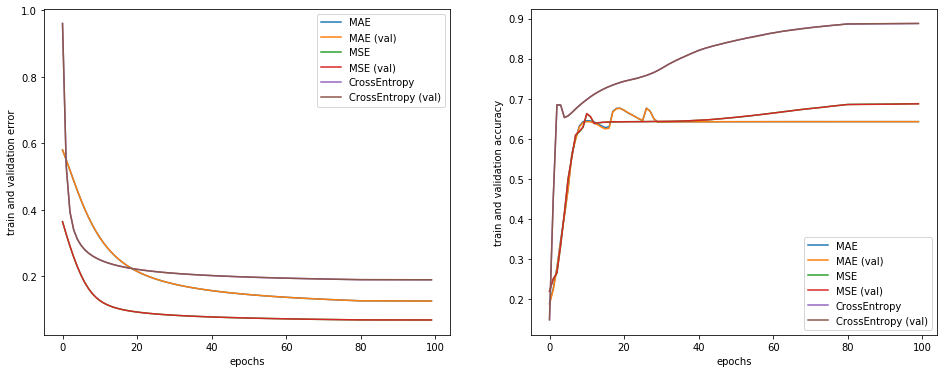

In [21]:
plt.figure(figsize=(16.,6.))
plt.subplot(1,2,1)
plt.xlabel('epochs')
plt.ylabel('train and validation error')
plt.plot(train_error_GD_MAE,label='MAE')
plt.plot(val_error_GD_MAE,label='MAE (val)')
plt.plot(train_error_GD_MSE,label='MSE')
plt.plot(val_error_GD_MSE,label='MSE (val)')
plt.plot(train_error_GD_CrEntropy,label='CrossEntropy')
plt.plot(val_error_GD_CrEntropy,label='CrossEntropy (val)')
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('epochs')
plt.ylabel('train and validation accuracy')
plt.plot(train_acc_GD_MAE,label='MAE')
plt.plot(val_acc_GD_MAE,label='MAE (val)')
plt.plot(train_acc_GD_MSE,label='MSE')
plt.plot(val_acc_GD_MSE,label='MSE (val)')
plt.plot(train_acc_GD_CrEntropy,label='CrossEntropy')
plt.plot(val_acc_GD_CrEntropy,label='CrossEntropy (val)')
plt.legend()
plt.savefig('logistic_lossVSaccuracy.png')
plt.show()

## Observations
1. mae < mse < cross entropy : recall for class 1
2. accuracy from logistic regression = 91.4%, from bayes = 96.9%, from naive bayes = 96.3% : number of parameters = 3*6, 36, 24

#### Increasing model capacity using polynomial regression

In [26]:
degrees=list(np.arange(1,11,1))
train_ERROR, val_ERROR, train_ACC, val_ACC = [],[],[],[]
for n in degrees:
    lr,alpha = 1, 0
    poly=PolynomialFeatures(n)
    #cross validate
    train_acc_CV, test_acc_CV = [],[]#final performance metrics

    for i,validation_data in enumerate(Cross_Validation_data):
#         print('validating on part %u'%i)
        remaining_data_for_training = np.concatenate(Cross_Validation_data[0:i]+Cross_Validation_data[i+1:])
        X_train, y_train = remaining_data_for_training[:,:-1], remaining_data_for_training[:,-1:]
        X_test, y_test = validation_data[:,:-1], validation_data[:,-1:]

        Phi_X = poly.fit_transform(X_train)
        Phi_Xt = poly.fit_transform(X_test)

        y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc = GradientDescent(Phi_X, y_train, Phi_Xt, y_test, epochs=100, lr=lr, alpha = alpha)
        tupple = classification_performance_metrics(y_pred_test,y_test[:,0],None)

        train_error_GD_CV.append(train_error)
        test_error_GD_CV.append(test_error)
        train_acc_GD_CV.append(train_acc)
        test_acc_GD_CV.append(test_acc)

        precisions_CV.append(tupple[0])
        recalls_CV.append(tupple[1])
        F1s_CV.append(tupple[2])
        macro_F1_CV.append(tupple[3]) #tupple[4] is confusion matrix
        train_acc_CV.append(accuracy(y_pred_train,y_train[:,0]))
        test_acc_CV.append(accuracy(y_pred_test, y_test[:,0]))

    precisions, recalls, F1s, macro_F1, train_acc, test_acc = sum(precisions_CV)/5, sum(recalls_CV)/5, sum(F1s_CV)/5, sum(macro_F1_CV)/5, sum(train_acc_CV)/5, sum(test_acc_CV)/5
    train_error_GD, test_error_GD, train_acc_GD, test_acc_GD = np.array(train_error_GD_CV).sum(axis=0)/5, np.array(test_error_GD_CV).sum(axis=0)/5, np.array(train_acc_GD_CV).sum(axis=0)/5, np.array(test_acc_GD_CV).sum(axis=0)/5
    
    train_ERROR.append(train_error_GD[-1])
    val_ERROR.append(test_error_GD[-1])
    train_ACC.append(train_acc)
    val_ACC.append(test_acc)
    print(train_acc,test_acc)

0.8878198854118617 0.8879842587879503
0.9568782767276292 0.9567881965096996
0.9596028679958367 0.9592901506063882
0.9633664094852886 0.9632339214460774
0.9632921940487906 0.9628947115710128
0.9644954698809727 0.9642941105013916
0.9650679601621148 0.9643364563813159
0.9596134800353386 0.9597565959361442
0.9614740216434271 0.9614528903322185
0.9363643376888481 0.9361363460005915


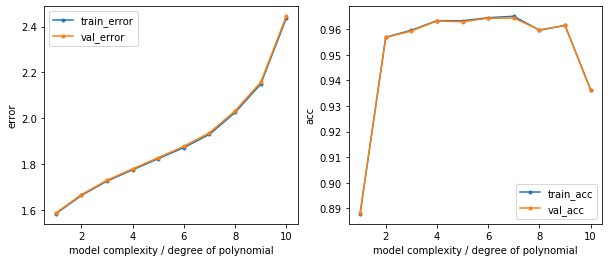

In [22]:
# listt=[train_ERROR, val_ERROR, train_ACC, val_ACC]
degrees=list(np.arange(1,11,1))
listt = np.load('logistic_BiasVarDecom.npy',allow_pickle=True)
plt.figure(figsize=(10.,4.))
plt.subplot(1,2,1)
plt.xlabel('model complexity / degree of polynomial')
plt.ylabel('error')
plt.plot(degrees, listt[0], label='train_error',marker='.')
plt.plot(degrees, listt[1], label='val_error',marker='.')
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('model complexity / degree of polynomial')
plt.ylabel('acc')
plt.plot(degrees, listt[2], label='train_acc',marker='.')
plt.plot(degrees, listt[3], label='val_acc',marker='.')
plt.legend()
plt.savefig('BiasVarianceDecomp.png')
plt.show()

# listt=[train_ERROR, val_ERROR, train_ACC, val_ACC]
# np.save('logistic_BiasVarDecom.npy',listt)

In [49]:
#FINALLY, train on complete TRAIN set and evaluate on TEST set
X_train, y_train = train_data[:,:-1], train_data[:,-1:]
poly=PolynomialFeatures(4)
Phi_X = poly.fit_transform(X_train)
Phi_Xt = poly.fit_transform(X_TEST)

y_pred_train, y_pred_TEST, train_error, TEST_error, train_acc, TEST_acc = GradientDescent_CrossEntropy(Phi_X, y_train, Phi_Xt, y_TEST, epochs=200, lr=1, alpha = 0)
test_metrics = classification_performance_metrics(y_pred_TEST,y_TEST[:,0],'logistic_CrossEntropy_4thDegree')
print('train acc, TEST acc, macro F1 score')
print( accuracy(y_pred_train, train_data[:,-1]), accuracy(y_pred_TEST, TEST_data[:,-1]), test_metrics[-2] )

train acc, TEST acc, macro F1 score
0.9658842736891207 0.9645492324654398 0.9643605953142721


## Stochastic gradient descent - logistic regression with 4th degree polynomial, CrEntropy loss

In [53]:
# Implementing stochastic gradient descent with Cross Entropy
def StochasticGradientDescent_CrossEntropy(X_train,y_train, X_test,y_test, epochs, lr, batch_size):    
    # X_train, X_test shape = (n,d)
    # y_train, y_test shape = (n,1) IMPORTANT - NOT in 1-hot
    
    # convert into one-hot representation
    y_train_1HOT = np.eye(6)[y_train[:,0].astype('uint8')]
    y_test_1HOT = np.eye(6)[y_test[:,0].astype('uint8')]
    
    train_error, test_error, train_acc, test_acc = [], [], [], []
    
    n,m=X_train.shape
    
    #initialise weights
    w = np.random.random((m,6)) #number of classes = 6    
    for _ in range(epochs):
        print('epoch %u'%_,end='\r')
        X_train_mini_batches = np.array_split(X_train, n//batch_size)
        y_train_mini_batches = np.array_split(y_train, n//batch_size)
        y_train_1HOT_mini_batches = np.array_split(y_train_1HOT, n//batch_size)
        
        for __ in range(len(X_train_mini_batches)):
            X_train_mini_batch = X_train_mini_batches[__]
            y_train_1HOT_mini_batch = y_train_1HOT_mini_batches[__]
            
            hypothesis_train = hypothesis(X_train_mini_batch, w)
            hypothesis_test = hypothesis(X_test, w)
            
            y_pred_train = X_train_mini_batch.dot(w)
            y_pred_test = X_test.dot(w)
            
            gradient = (2*((X_train_mini_batch.T).dot(hypothesis_train - y_train_1HOT_mini_batch)) / n) + 2*alpha*w 
            w = w - lr * gradient
        
            train_error.append(cross_entropy_loss(y_train_1HOT_mini_batch, hypothesis_train))
            test_error.append(cross_entropy_loss(y_test_1HOT, hypothesis_test))           
            
            y_pred_train = np.argmax(hypothesis_train,axis=1)
            y_pred_test = np.argmax(hypothesis_test,axis=1)

            train_acc.append(accuracy(y_pred_train, y_train_mini_batches[__][:,0].astype(np.uint8)))
            test_acc.append(accuracy(y_pred_test, y_test[:,0].astype(np.uint8)))

        if _ == epochs-5:
            lr/=10.
        w = w - lr * gradient
        
    hypothesis_train = hypothesis(X_train, w)
    hypothesis_test = hypothesis(X_test, w)

    y_pred_train = np.argmax(hypothesis_train,axis=1)
    y_pred_test = np.argmax(hypothesis_test,axis=1)
    
    return y_pred_train, y_pred_test, train_error, test_error, train_acc, test_acc

In [54]:
#FINALLY, train on complete TRAIN set and evaluate on TEST set
X_train, y_train = train_data[:,:-1], train_data[:,-1:]
poly=PolynomialFeatures(4)
Phi_X = poly.fit_transform(X_train)
Phi_Xt = poly.fit_transform(X_TEST)

y_pred_train, y_pred_TEST, train_error, TEST_error, train_acc, TEST_acc = StochasticGradientDescent_CrossEntropy(Phi_X, y_train, Phi_Xt, y_TEST, epochs=50, lr=1, batch_size=100)
test_metrics = classification_performance_metrics(y_pred_TEST,y_TEST[:,0],'logistic_CrossEntropy_4thDegreeSGD')
print('train acc, TEST acc, macro F1 score')
print( accuracy(y_pred_train, train_data[:,-1].astype(np.uint8)), accuracy(y_pred_TEST, TEST_data[:,-1].astype(np.uint8)), test_metrics[-2] )

train acc, TEST acc, macro F1 score
0.9592053092466553 0.9587821219574252 0.9584733121930048


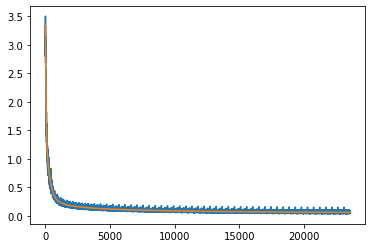

In [55]:
plt.plot(train_error)
plt.plot(TEST_error)
plt.show()